In [2]:
ZONE = "south"

In [3]:
%matplotlib inline

import sys
import os
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tsd
import geojson
import json
import folium
import rasterio, rasterio.mask
from PIL import Image, ImageDraw, ImageFont

sys.path.append("../forestry_yield_estimation")
import vistools, utils
from preprocessing import get_timeseries, read_raw_points_data, read_raw_polygons_data

pd.options.mode.chained_assignment = None
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.4)

root = Path("..")
data_path = root / "data"
output_path = Path("../report/img")

In [4]:
raw_ts = get_timeseries(data_path, ZONE)
ts = raw_ts.query("n_pixels >= 200")

Found 76 images


Reading images:   0%|          | 0/122 [00:00<?, ?it/s]

In [5]:
df = read_raw_points_data(data_path).query("zone == @ZONE")

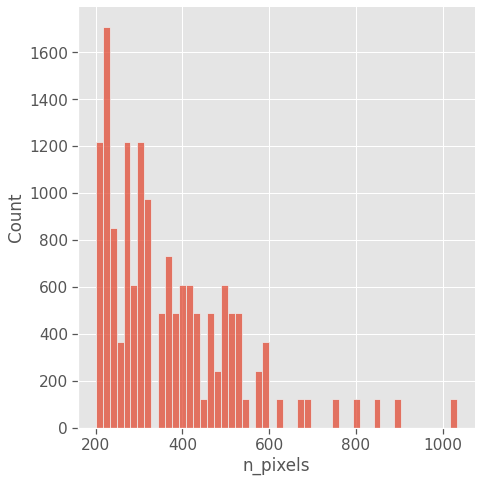

In [6]:
sns.displot(data=ts, x="n_pixels", height=7)

# Effect of normalisation

vv identity R² = 19%
vh identity R² = 20%


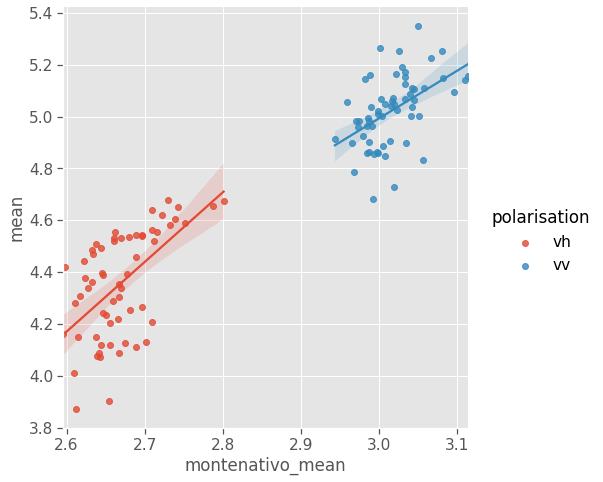

In [22]:
grouped_ts = ts.groupby(["date", "polarisation"])[["montenativo_mean", "mean", "norm_mean", "rain"]].mean().reset_index()

for pol in ["vv", "vh"]:
    data = grouped_ts.query("polarisation == @pol")[["montenativo_mean", "mean"]]
    r_sq = 1 - (data["mean"] - data["montenativo_mean"]).var() / data["mean"].var()
    print(f"{pol} identity R² = {r_sq:.0%}")

g = sns.lmplot(data=grouped_ts, x="montenativo_mean", y="mean", hue="polarisation", height=7)
g.tight_layout()
plt.savefig(output_path/"normalization"/"south_correlation.png")

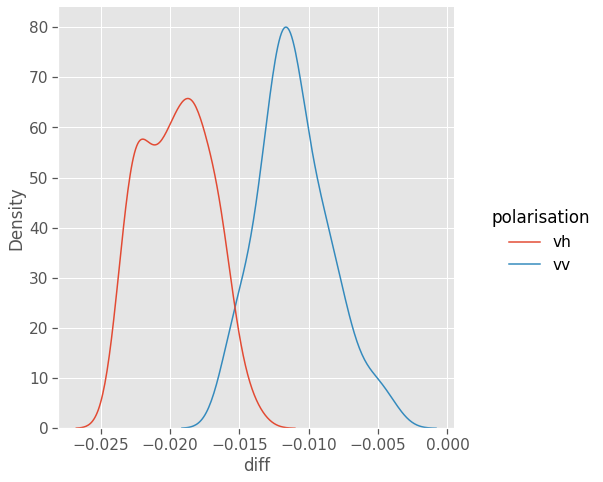

In [23]:
# Difference in variance before and after normalisation
diff = ts.groupby(["polarisation", "rodal"])[["mean", "norm_mean"]].std().diff(axis=1)["norm_mean"].rename("diff").reset_index()
sns.displot(data=diff, x="diff", hue="polarisation", height=7, kind="kde")

# Aggregate study (scale: zone)

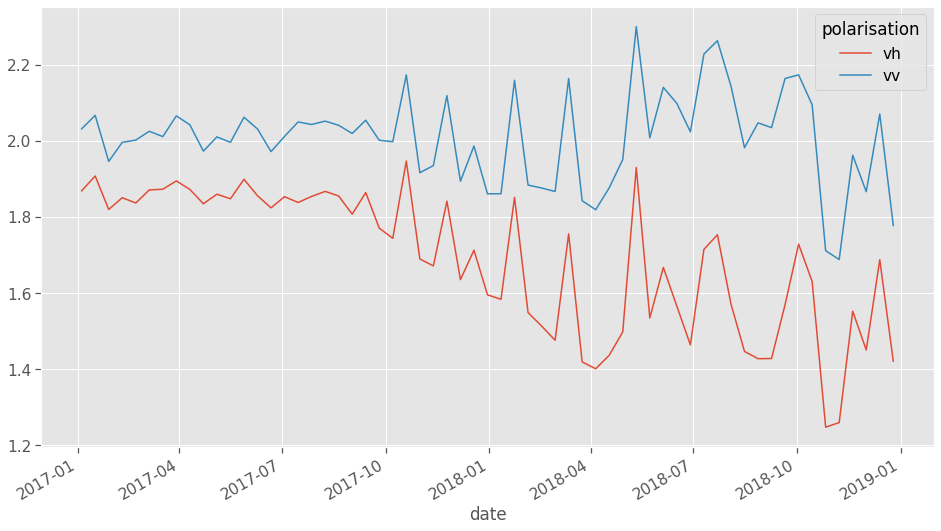

In [24]:
norm_mean = ts.groupby(["date", "polarisation"])[["norm_mean"]].mean().unstack().droplevel(0, axis=1)
norm_mean.plot(figsize=(16, 9))
plt.savefig(output_path/"volume_prediction"/"zone_scale_timeseries.png")

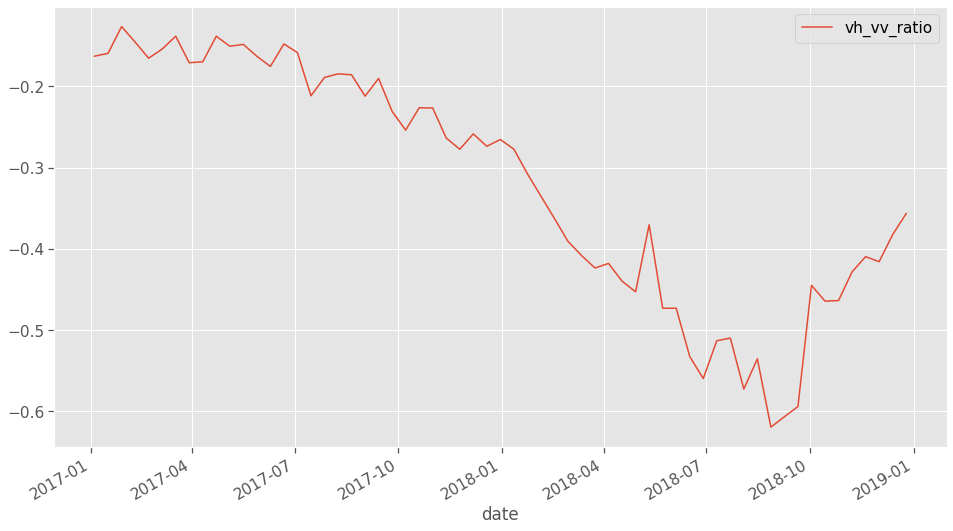

In [25]:
(norm_mean["vh"] - norm_mean["vv"]).rename("vh_vv_ratio").plot(figsize=(16, 9))
plt.legend()
plt.savefig(output_path/"volume_prediction"/"zone_scale_timeseries_ratio.png")

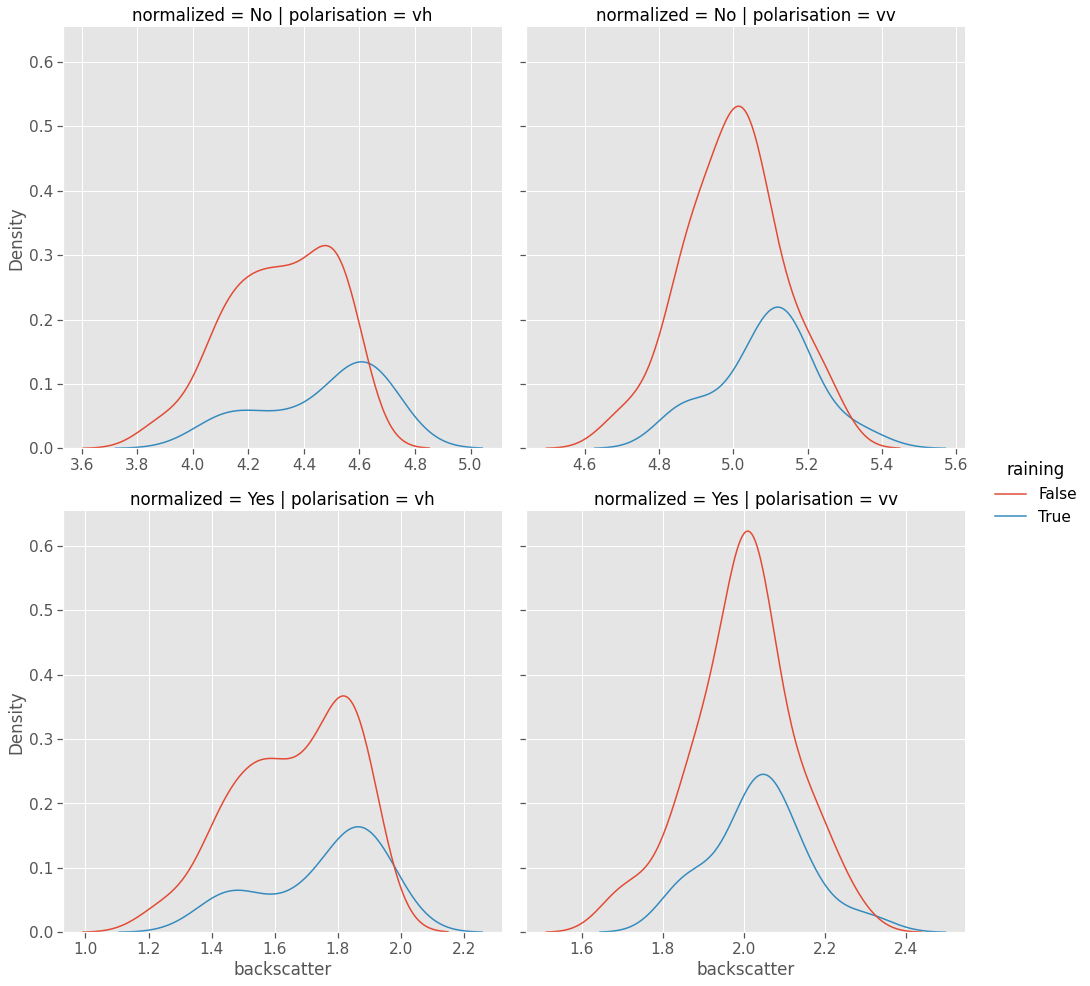

In [27]:
data = (
    grouped_ts
    .assign(raining=lambda df: df.rain>0)
    .rename(columns={"mean": "No", "norm_mean": "Yes"})
    .melt(id_vars=["raining", "polarisation"], value_vars=["Yes", "No"], var_name="normalized", value_name="backscatter")
)
sns.displot(
    data=data,
    x="backscatter",
    hue="raining",
    col="polarisation",
    row="normalized",
    kind="kde",
    row_order=["No", "Yes"],
    facet_kws=dict(sharex=False),
    height=7
)
plt.savefig(output_path/"normalization"/"south_rain_effect.png")

# Exploration

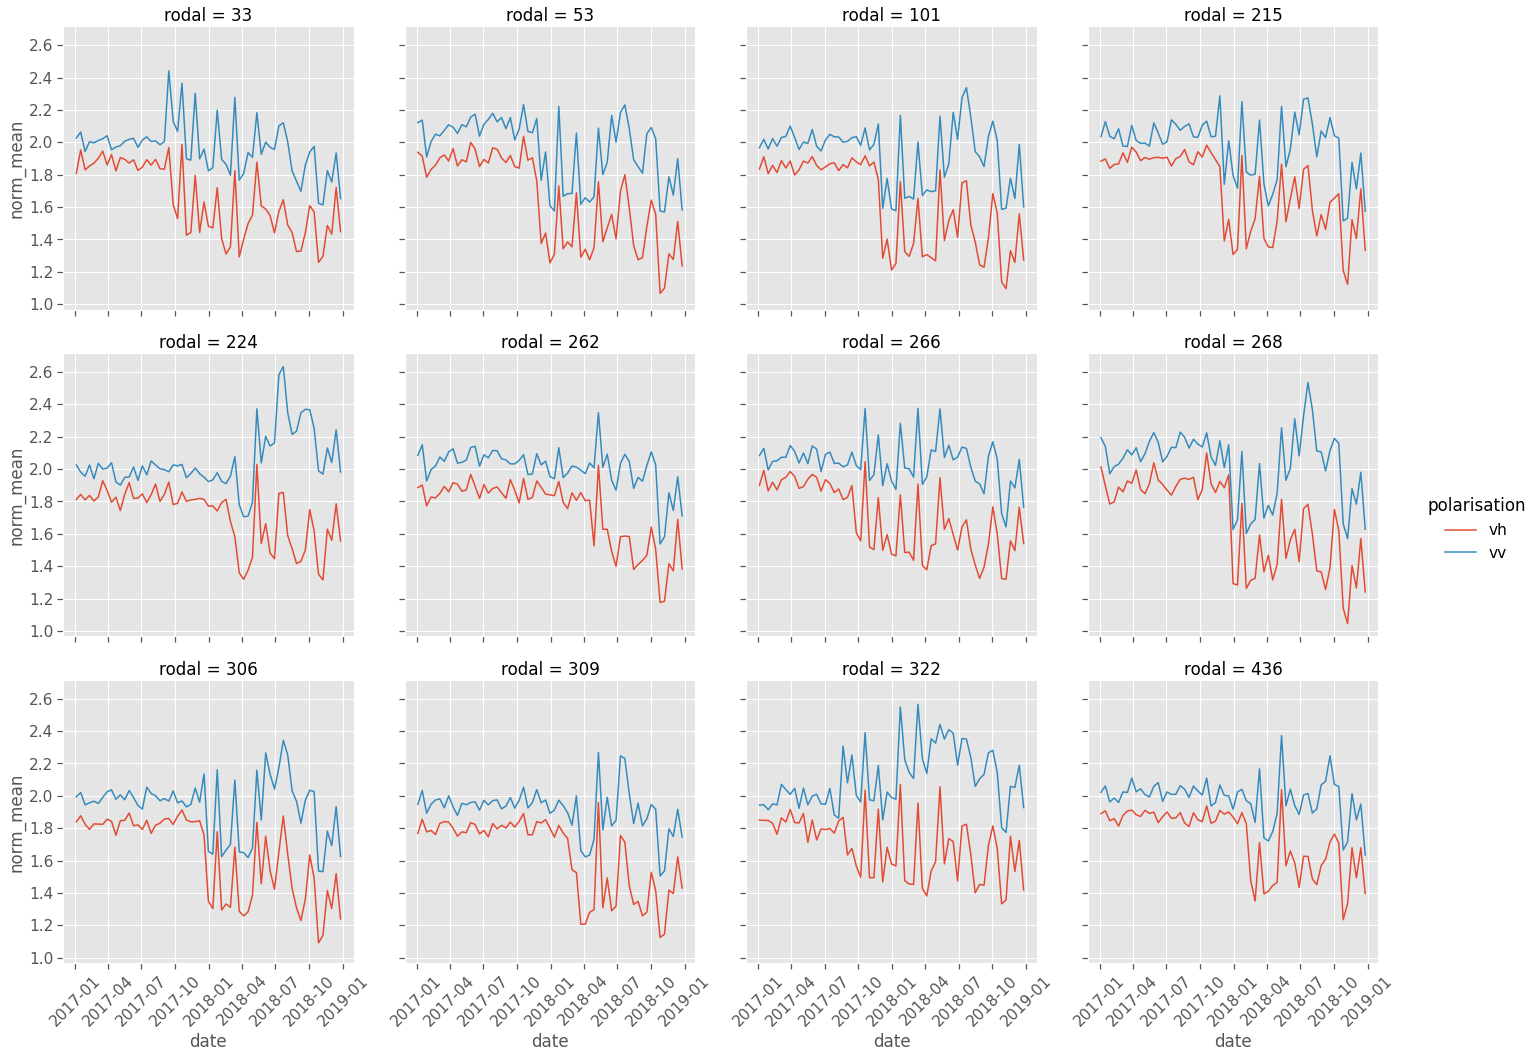

In [28]:
# We select a few random rodals
selected_rodals = np.random.choice(ts["rodal"].unique(), size=12, replace=False)

g = sns.relplot(
    data=ts[ts["rodal"].isin(selected_rodals)],
    hue="polarisation",
    x="date",
    y="norm_mean",
    col="rodal",
    col_wrap=4,
    kind="line",
)
g.set_xticklabels(rotation=45)
g.tight_layout()
plt.savefig(output_path/"volume_prediction"/"rodal_scale_timeseries.png")

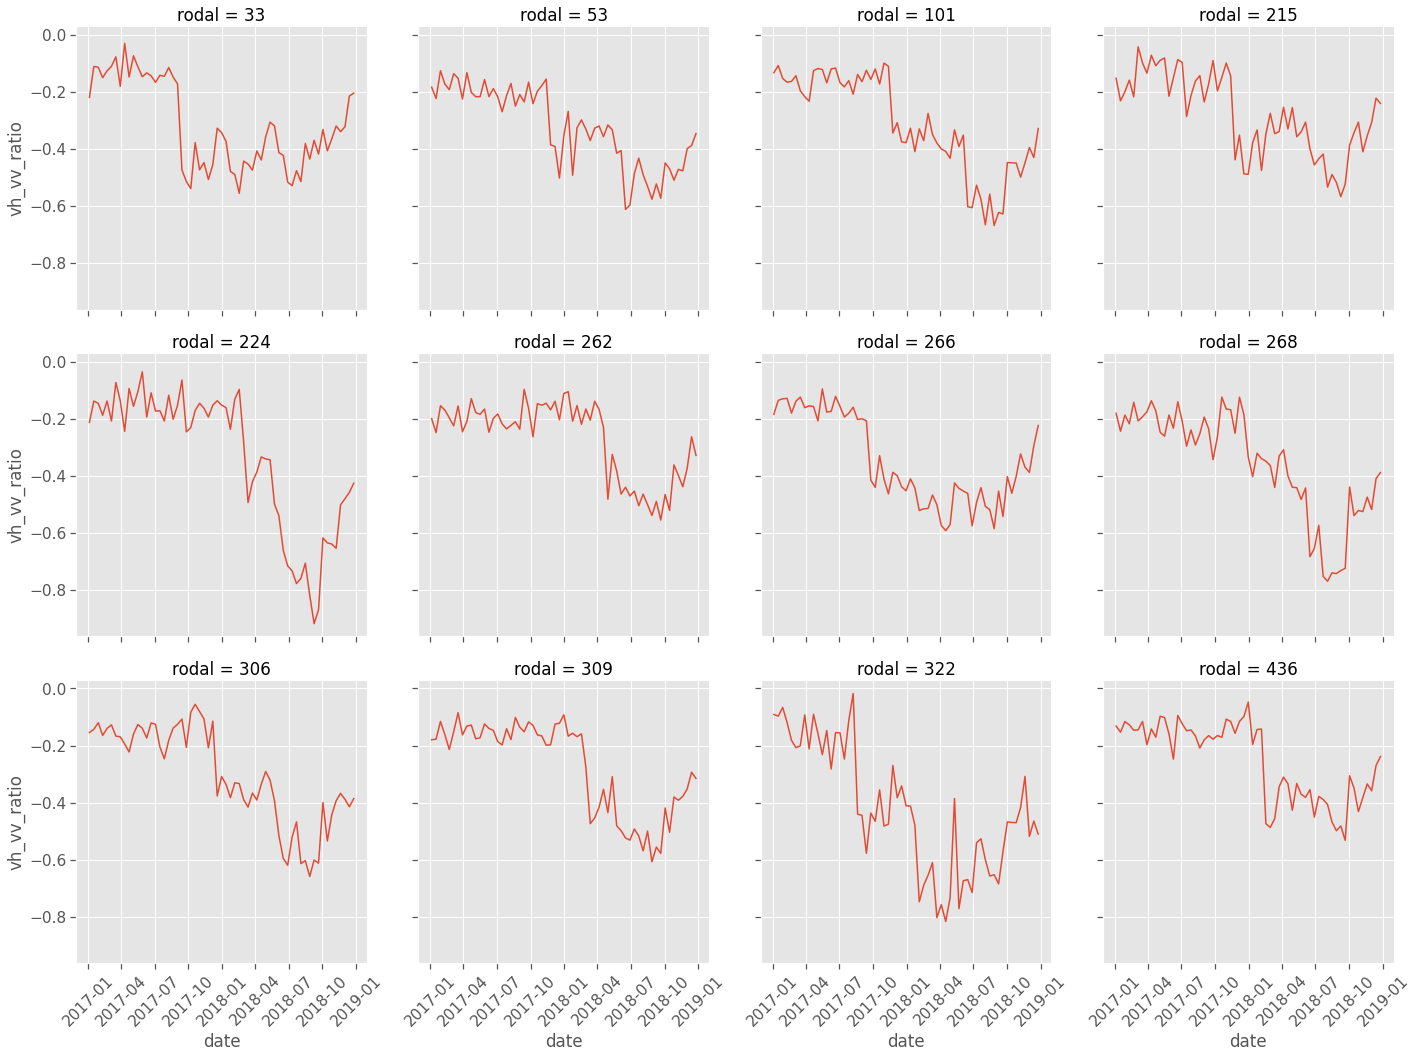

In [29]:
data = (
    ts[ts["rodal"].isin(selected_rodals)]
    .set_index(["date", "rodal", "polarisation"])
    ["norm_mean"]
    .unstack()
    .eval("vh - vv")
    .rename("vh_vv_ratio")
    .reset_index()
)

g = sns.relplot(
    data=data,
    x="date",
    y="vh_vv_ratio",
    col="rodal",
    col_wrap=4,
    kind="line",
)
g.set_xticklabels(rotation=45)
g.tight_layout()
plt.savefig(output_path/"volume_prediction"/"rodal_scale_timeseries_ratio.png")

In [19]:
mean_backscatter = {
    (str(date)[:10], rodal, polarisation): ts.loc[(ts["date"] <= date) & (ts["rodal"] == rodal) & (ts["polarisation"] == polarisation), "norm_mean"].mean()
    for date, rodal, polarisation in tqdm(itertools.product(df["date"].unique(), df["rodal"].unique(), ["vv", "vh"]))
    if (date > ts["date"].min()) and (rodal in ts["rodal"])
}

#median_backscatter = {
#    (str(date)[:10], rodal, polarisation): np.median(np.concatenate(ts.loc[(ts["date"] <= date) & (ts["rodal"] == rodal) & (ts["polarisation"] == polarisation), "pixels"].tolist()))
#    for date, rodal, polarisation in tqdm(itertools.product(df["date"].unique(), df["rodal"].unique(), ["vv", "vh"]))
#    if (date > ts["date"].min()) and (rodal in ts["rodal"].tolist())
#}

for pol in ["vv", "vh"]:
    df[f"mean_backscatter_{pol}"] = df.apply(
        lambda row: mean_backscatter.get((str(row["date"])[:10], row["rodal"], pol)),
        axis=1
    )

#for pol in ["vv", "vh"]:
#    df[f"median_backscatter_{pol}"] = df.apply(
#        lambda row: median_backscatter.get((str(row["date"])[:10], row["rodal"], pol)),
#        axis=1
#    )

df

0it [00:00, ?it/s]

,date,zone,rodal,lon,lat,easting,northing,plant_date,age,volume,...,basal_area,height,dominant_height,pre_cut,objetivo,nfustes,nfustes8,bloque,mean_backscatter_vv,mean_backscatter_vh
0,2016-06-18,south,538,-57.350375,-32.254982,466997,6431247,2008-09-15,7.75,207.6,...,28.04,20.95,23.46,False,IPT,1300.0,1233.3,BLOQUE:22524_24,NaN,NaN
1,2016-06-18,south,534,-57.348124,-32.265950,467213,6430032,2008-09-15,7.75,233.6,...,29.48,21.63,27.11,False,IPT,1300.0,1233.3,BLOQUE:22524_28,NaN,NaN
2,2013-06-08,south,506,-57.346948,-32.261090,467322,6430571,2008-09-15,4.67,74.2,...,14.99,14.67,16.30,False,IPT,1000.0,866.7,BLOQUE:22524_28,NaN,NaN
3,2016-06-18,south,519,-57.337490,-32.258716,468212,6430837,2008-09-15,7.75,149.5,...,21.97,18.95,22.47,False,IPT,1133.3,1033.3,BLOQUE:22524_31,NaN,NaN
4,2016-06-18,south,526,-57.341909,-32.267753,467799,6429834,2008-09-15,7.75,201.3,...,24.53,22.20,26.83,False,IPT,1200.0,1100.0,BLOQUE:22524_39,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,2017-10-06,south,540,-57.365470,-32.254425,465575,6431304,2008-09-15,9.09,257.2,...,29.65,22.53,28.83,True,IPC,1433.3,1300.0,BLOQUE:22524_8,1.983075,1.834764
470,2017-03-04,south,480,-57.348674,-32.271027,467163,6429469,2008-09-15,8.50,288.3,...,32.41,24.19,29.76,True,IPC,1333.3,1266.7,BLOQUE:22524_40,NaN,NaN
471,2017-03-04,south,480,-57.349913,-32.270076,467046,6429574,2008-09-15,8.50,248.7,...,29.23,23.11,26.29,True,IPC,1133.3,1100.0,BLOQUE:22524_40,NaN,NaN
472,2017-03-10,south,526,-57.340490,-32.268803,467933,6429718,2008-09-15,8.50,197.6,...,24.36,21.87,28.69,True,IPC,1300.0,1200.0,BLOQUE:22524_39,NaN,NaN


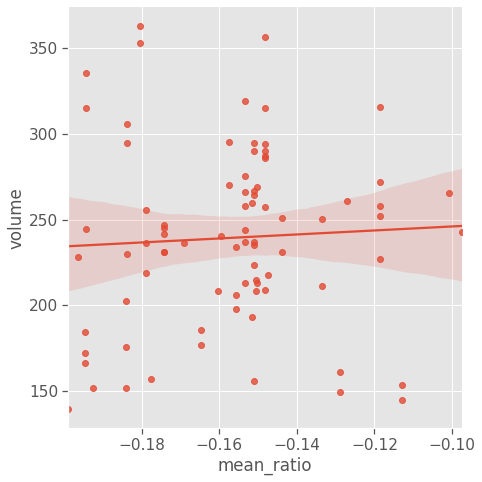

In [20]:
df["mean_ratio"] = df["mean_backscatter_vh"] - df["mean_backscatter_vv"]

g = sns.lmplot(data=df.dropna(subset=["mean_backscatter_vv"]), x="mean_ratio", y="volume", height=7)
g.tight_layout()
plt.savefig(output_path/"volume_prediction"/"rodal_scale_lr_ratio.png")

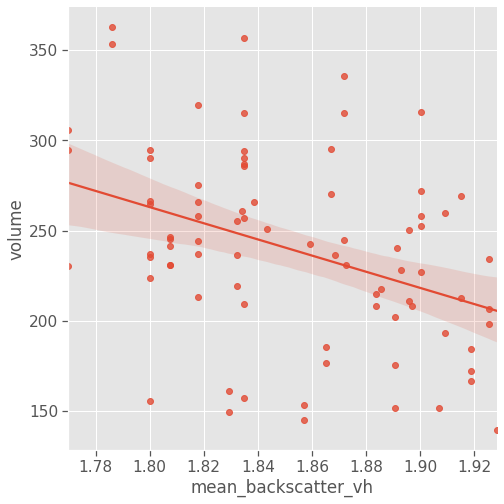

In [21]:
sns.lmplot(data=df.dropna(subset=["mean_backscatter_vv"]), x="mean_backscatter_vh", y="volume", height=7)
g.tight_layout()
plt.savefig(output_path/"volume_prediction"/"rodal_scale_lr_vh.png")